# load data

In [1]:
from mxnet import gluon
import zipfile

data_dir = '../data'
fname = gluon.utils.download(
    'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/hotdog.zip', 
    path = data_dir, sha1_hash = 'fba480ffa8aa7e0febbb511d181409f899b9baa5')

with zipfile.ZipFile(fname, 'r') as f:
    f.extractall(data_dir)

/home/dyjng/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
from mxnet import nd
from mxnet import image
from mxnet import gluon

train_augs = [
    image.HorizontalFlipAug(.5), 
    image.RandomCropAug((224, 224)), 
#     image.CenterCropAug((224, 224))
]

test_augs = [
    image.CenterCropAug((224, 224))
#     image.RandomCropAug((224, 224))
]

def transform(data, label, augs):
    data = data.astype('float32')
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2, 0, 1))
    return data, nd.array([label]).asscalar().astype('float32')

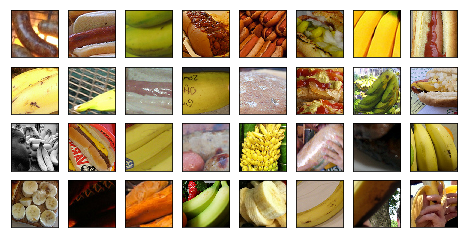

In [3]:
%matplotlib inline
import sys
sys.path.append('..')
import utils

train_imgs = gluon.data.vision.ImageFolderDataset(
    data_dir + '/hotdog/train', 
    transform = lambda X, y: transform(X, y, train_augs))
test_imgs = gluon.data.vision.ImageFolderDataset(
    data_dir + '/hotdog/test', 
    transform = lambda X, y: transform(X, y, test_augs))

data = gluon.data.DataLoader(train_imgs, 32, shuffle = True)
for X, _ in data:
    X = X.transpose((0, 2, 3, 1)).clip(0, 255) / 255
    utils.show_images(X, 4, 8)   # 4 row and 8 column total 32 images
    break

# Model and Trainning

In [4]:
from mxnet.gluon.model_zoo import vision as models

pretrained_net = models.resnet18_v2(pretrained = True)

In [5]:
models.resnet??

In [6]:
# pretrained_net.output
pretrained_net.classifier

HybridSequential(
  (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False)
  (1): Activation(relu)
  (2): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True)
  (3): Flatten
  (4): Dense(512 -> 1000, linear)
)

In [7]:
# 1st conv 1st filter 1st channel
# pretrained_net.features[1].weight.data()[5][1]
# pretrained_net.features[5][0].conv1.weight.data()[62][50]
pretrained_net.features

HybridSequential(
  (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=True)
  (1): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False)
  (3): Activation(relu)
  (4): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
  (5): HybridSequential(
    (0): BasicBlockV2(
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False)
      (conv1): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False)
      (conv2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BasicBlockV2(
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False)
      (conv1): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False)
      (

In [8]:
from mxnet import init

finetune_net = models.resnet18_v2(classes = 2)
finetune_net.features = pretrained_net.features
finetune_net.classifier.initialize(init.Xavier())

In [9]:
def train(net, ctx, batch_size = 64, epochs = 10, learning_rate = 0.01, wd = 0.001):
    train_data = gluon.data.DataLoader(train_imgs, batch_size, shuffle = True)
    test_data = gluon.data.DataLoader(test_imgs, batch_size, shuffle = True)
    
    # assert the initialize of net in ctx
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    # trian 
    trainer = gluon.Trainer(net.collect_params(), 'sgd', 
                            {'learning_rate': learning_rate, 'wd': wd})
    utils.train(train_data, test_data, net, loss, trainer, ctx, epochs)

In [10]:
ctx = utils.try_all_gpus()
train(finetune_net, ctx)

Start training on  [gpu(0)]
Epoch 0. Loss: 0.387, Train acc 0.85, Test acc 0.92, Time 13.6 sec
Epoch 1. Loss: 0.212, Train acc 0.93, Test acc 0.94, Time 12.4 sec
Epoch 2. Loss: 0.165, Train acc 0.94, Test acc 0.94, Time 12.3 sec
Epoch 3. Loss: 0.127, Train acc 0.96, Test acc 0.94, Time 12.4 sec
Epoch 4. Loss: 0.122, Train acc 0.96, Test acc 0.95, Time 12.4 sec
Epoch 5. Loss: 0.101, Train acc 0.97, Test acc 0.95, Time 12.3 sec
Epoch 6. Loss: 0.086, Train acc 0.97, Test acc 0.96, Time 12.5 sec
Epoch 7. Loss: 0.073, Train acc 0.98, Test acc 0.95, Time 12.5 sec
Epoch 8. Loss: 0.074, Train acc 0.98, Test acc 0.96, Time 12.5 sec
Epoch 9. Loss: 0.062, Train acc 0.98, Test acc 0.96, Time 12.5 sec


In [11]:
scratch_net = models.resnet18_v2(classes = 2)
scratch_net.initialize(init = init.Xavier())
train(scratch_net, ctx)

Start training on  [gpu(0)]
Epoch 0. Loss: 0.459, Train acc 0.78, Test acc 0.75, Time 12.6 sec
Epoch 1. Loss: 0.359, Train acc 0.84, Test acc 0.85, Time 12.4 sec
Epoch 2. Loss: 0.338, Train acc 0.86, Test acc 0.80, Time 12.4 sec
Epoch 3. Loss: 0.313, Train acc 0.87, Test acc 0.67, Time 12.4 sec
Epoch 4. Loss: 0.316, Train acc 0.87, Test acc 0.81, Time 12.4 sec
Epoch 5. Loss: 0.317, Train acc 0.86, Test acc 0.68, Time 12.4 sec
Epoch 6. Loss: 0.305, Train acc 0.87, Test acc 0.85, Time 12.4 sec
Epoch 7. Loss: 0.285, Train acc 0.89, Test acc 0.83, Time 12.5 sec
Epoch 8. Loss: 0.278, Train acc 0.88, Test acc 0.85, Time 12.5 sec
Epoch 9. Loss: 0.267, Train acc 0.90, Test acc 0.74, Time 12.5 sec


In [12]:
import matplotlib.pyplot as plt

def classify_hotdog(net, fname):
    with open(fname, 'rb') as f:
        img = image.imdecode(f.read())
    data, _ = transform(img, -1, test_augs)
    plt.imshow(data.transpose((1, 2, 0)).asnumpy() / 255)
    data = data.expand_dims(axis = 0)
    out = net(data.as_in_context(ctx[0]))
    out = nd.SoftmaxActivation(out)
    pred = int(nd.argmax(out, axis = 1).asscalar())
    prob = out[0][pred].asscalar()
    label = train_imgs.synsets
    return 'with prob = %f, %s' % (prob, label[pred])

'with prob = 0.989929, hotdog'

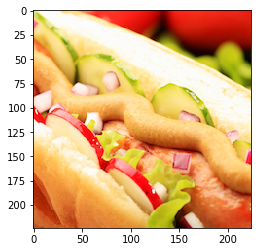

In [13]:
classify_hotdog(finetune_net, '../img/real_hotdog.jpg')

'with prob = 0.812763, hotdog'

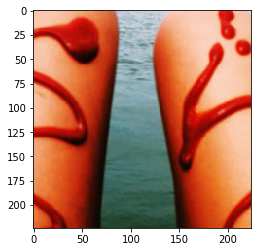

In [14]:
classify_hotdog(finetune_net, '../img/leg_hotdog.jpg')

'with prob = 0.618790, not-hotdog'

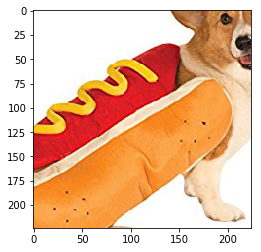

In [15]:
classify_hotdog(finetune_net, '../img/dog_hotdog.jpg')

In [18]:
weight = pretrained_net.classifier[4].weight
hotdog_w = nd.split(weight.data(), 1000, axis=0)[713]
hotdog_w.shape

(1, 512)